In [1]:
import nfl_data_py as nfl
import pandas as pd
import os
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# pbp = nfl.import_pbp_data([2022])
pbp = pd.read_csv('scrape/nfl_data_py/df_pbp_2016_2022.csv')

C:\Users\grant\AppData\Local\Temp\ipykernel_4232\892554206.py:2: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,209,210,213,214,218,219,220,222,224,226,233,234,235,236,237,238,243,244,245,248,249,253,254,255,260,262,263,266,267,268,269,283,284,301) have mixed types. Specify dtype option on import or set low_memory=False.
  pbp = pd.read_csv('scrape/nfl_data_py/df_pbp_2016_2022.csv')


In [3]:
df = pbp[(pbp['season_type'] == 'REG') & (pbp['desc'] == 'END GAME')]
cols = ['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']
df = df[cols]
df['home_win'] = df['home_score'] > df['away_score']

home = df[['season', 'week', 'home_team', 'home_win']].rename(columns={'home_team': 'team', 'home_win': 'win'})
away = df[['season', 'week', 'away_team', 'home_win']].rename(columns={'away_team': 'team', 'home_win': 'win'})
away['win'] = ~away['win']

weekly_wins = pd.concat([home, away]).reset_index(drop=True)

season_wins = weekly_wins.drop(columns=['week']).groupby(['season', 'team']).sum().reset_index()
season_wins.rename(columns={'win': 'win_count'}, inplace=True)
season_wins.sort_values('win_count', ascending=False, inplace=True)

In [4]:
pbp_rp = pbp[(pbp['pass'] == 1) | (pbp['rush'] == 1)]
pbp_rp = pbp_rp.dropna(subset=['epa', 'posteam', 'defteam'])

group_cols = ['season', 'posteam']
off_epa = pbp_rp.groupby(group_cols)['epa'].mean().reset_index().rename(columns = {'epa' : 'all'})
off_pass_epa = pbp_rp[(pbp_rp['pass'] == 1)].groupby(group_cols)['epa'].mean().reset_index().rename(columns = {'epa' : 'pass'})
off_epa = pd.merge(off_epa, off_pass_epa, on = group_cols)
off_rush_epa = pbp_rp[(pbp_rp['rush'] == 1)].groupby(group_cols)['epa'].mean().reset_index().rename(columns = {'epa' : 'rush'})
off_epa = pd.merge(off_epa, off_rush_epa, on = group_cols).rename(columns = {'posteam' : 'team'})

group_cols = ['season', 'defteam']
def_epa = pbp_rp.groupby(group_cols)['epa'].mean().reset_index().rename(columns = {'epa' : 'all'})
def_pass_epa = pbp_rp[(pbp_rp['pass'] == 1)].groupby(group_cols)['epa'].mean().reset_index().rename(columns = {'epa' : 'pass'})
def_epa = pd.merge(def_epa, def_pass_epa, on = group_cols)
def_rush_epa = pbp_rp[(pbp_rp['rush'] == 1)].groupby(group_cols)['epa'].mean().reset_index().rename(columns = {'epa' : 'rush'})
def_epa = pd.merge(def_epa, def_rush_epa, on = group_cols).rename(columns = {'defteam' : 'team'})

epa = pd.merge(off_epa, def_epa, on = ['season', 'team'], suffixes=('_off', '_def'))
epa['net'] = epa['all_off'] - epa['all_def']
epa.sort_values('net').head()

,season,team,all_off,pass_off,rush_off,all_def,pass_def,rush_def,net
64,2018,ARI,-0.237184,-0.266105,-0.186743,0.029246,0.038277,0.018150,-0.266431
16,2016,LA,-0.202796,-0.221529,-0.169896,0.020400,0.078084,-0.077188,-0.223195
152,2020,NYJ,-0.115883,-0.097305,-0.146328,0.104651,0.244355,-0.123028,-0.220534
142,2020,JAX,-0.051078,-0.038170,-0.080192,0.167403,0.303112,-0.007568,-0.218481
127,2019,WAS,-0.133460,-0.113887,-0.166232,0.083162,0.187033,-0.057664,-0.216622


In [5]:
df = pd.merge(season_wins, epa, on = ['season', 'team'])
df.head()

,season,team,win_count,all_off,pass_off,rush_off,all_def,pass_def,rush_def,net
0,2022,KC,14,0.181334,0.280231,-0.021943,0.008484,0.040285,-0.056494,0.172850
1,2019,BAL,14,0.174377,0.269817,0.074100,-0.072127,-0.073504,-0.069584,0.246505
2,2022,PHI,14,0.114468,0.130672,0.094366,-0.065302,-0.083996,-0.034751,0.179770
3,2020,KC,14,0.176200,0.269951,-0.027777,0.067781,0.085094,0.038145,0.108419
4,2021,TB,13,0.122775,0.170189,0.019640,-0.067820,-0.029805,-0.158512,0.190595


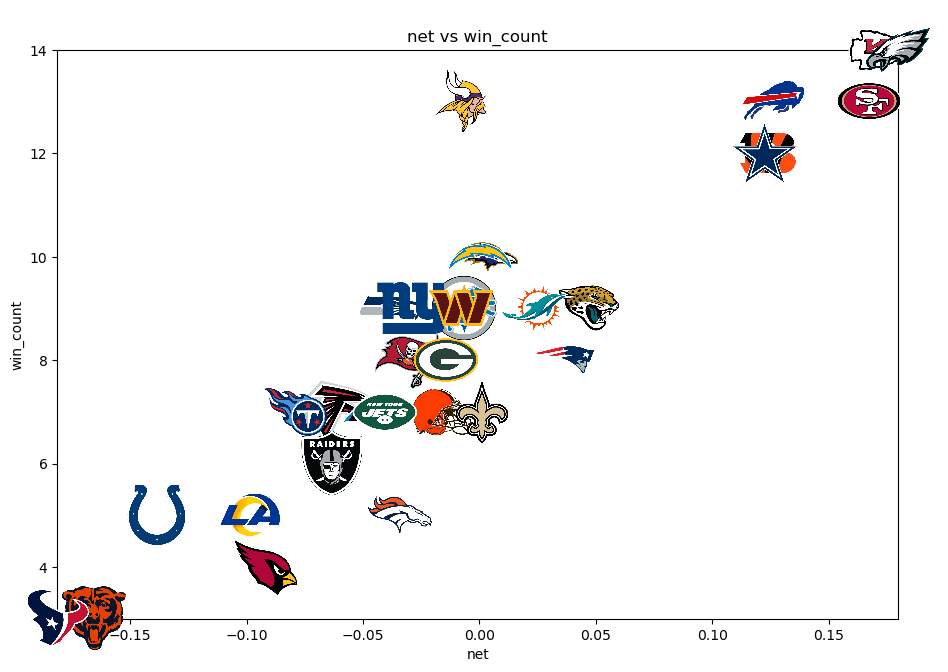

In [6]:
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

logos = nfl.import_team_desc()[['team_abbr', 'team_logo_espn']]

def chart_epa_vs_wins(df, x_name='net', y_name='win_count'):
        
    logo_paths = []
    team_abbr = []
    if not os.path.exists("logos"):
        os.makedirs("logos")

    for team in range(len(logos)):
        urllib.request.urlretrieve(logos['team_logo_espn'][team], f"logos/{logos['team_abbr'][team]}.tif")
        logo_paths.append(f"logos/{logos['team_abbr'][team]}.tif")
        team_abbr.append(logos['team_abbr'][team])

    data = {'team_abbr' : team_abbr, 'logo_path' : logo_paths}
    logo_data = pd.DataFrame(data)

    epa_with_logos = pd.merge(df, logo_data, left_on = 'team', right_on = 'team_abbr')

    
    plt.rcParams["figure.figsize"] = [10, 7]
    plt.rcParams["figure.autolayout"] = True

    def getImage(path):
        return OffsetImage(plt.imread(path, format="tif"), zoom=.1)

    x = epa_with_logos[x_name]
    y = epa_with_logos[y_name]
    paths = epa_with_logos['logo_path']

    fig, ax = plt.subplots()

    for x0, y0, path in zip(x, y, paths):
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

    xmin = min(x)
    xmax = max(x)
    ymin = min(y)
    ymax = max(y)

    # buffer = 0.05
    buffer = 0
    plt.xlim(xmin-buffer, xmax+buffer)
    plt.ylim(ymin-buffer, ymax+buffer)

    plt.title(f"{x_name} vs {y_name}")
    plt.xlabel(f"{x_name}")
    plt.ylabel(f"{y_name}")
    plt.show()
    
chart_epa_vs_wins(df[df['season'] == 2022])

In [8]:
correlation = df.drop('season', axis=1).corr()['win_count'].drop('win_count')
correlation

C:\Users\grant\AppData\Local\Temp\ipykernel_27596\233424071.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.drop('season', axis=1).corr()['win_count'].drop('win_count')


all_off     0.694046
pass_off    0.690321
rush_off    0.406391
all_def    -0.463276
pass_def   -0.520158
rush_def   -0.167479
net         0.840398
Name: win_count, dtype: float64

In [9]:
correlation = df[df['season'] == 2022].drop('season', axis=1).corr()['win_count'].drop('win_count')
correlation

C:\Users\grant\AppData\Local\Temp\ipykernel_15472\751331806.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df[df['season'] == 2022].drop('season', axis=1).corr()['win_count'].drop('win_count')


all_off     0.827880
pass_off    0.840637
rush_off    0.384532
all_def    -0.402120
pass_def   -0.438205
rush_def   -0.181815
net         0.906211
Name: win_count, dtype: float64

In [10]:
import statsmodels.api as sm

X = df[['all_off', 'pass_off', 'rush_off', 'all_def', 'pass_def', 'rush_def', 'net']]
X = sm.add_constant(X)

y = df['win_count']

model = sm.OLS(y, X).fit()

model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              win_count   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     96.31
Date:                Sun, 17 Sep 2023   Prob (F-statistic):           2.14e-58
Time:                        07:44:00   Log-Likelihood:                -424.10
No. Observations:                 224   AIC:                             862.2
Df Residuals:                     217   BIC:                             886.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.4784      0.284     29.824      0.000       7.918       9.039
all_off       22.5225     11.932      1.888      0.060      -0.994      46.039
pass_off       7.2793      9.440      0.771      0.441     -11.327      25.885
rush_off       1.9330      5.126      0.377      0.706      -8.171      12.037
all_def       32.0399     14.768      2.169      0.031       2.932      61.148
pass_def     -40.1704     12.880     -3.119      0.002     -65.556     -14.785
rush_def     -18.6320      7.350     -2.535      0.012     -33.119      -4.145
net           -9.5174      8.671     -1.098      0.274     -26.607       7.573
==============================================================================
Omnibus:                       10.176   Durbin-Watson:                   1.576
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               13.242
Skew:                          -0.336   Prob(JB):                      0.00133
Kurtosis:                       3.983   Cond. No.                     5.84e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.72e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

- P-values
    - P-values help us determine the statistical significance of the coefficients. A smaller p-value (typically < 0.05) indicates that you can reject the null hypothesis and that the coefficient is statistically significant.
    - pass_def and rush_def have p-values less than 0.05, which indicates that at a 95% confidence level these predictors are statistically significant in this model
- Multicollinearity Warning:
The note at the bottom indicates potential multicollinearity problems. Multicollinearity occurs when independent variables in a regression model are correlated. This can lead to unreliable and unstable estimates of regression coefficients. Let's remove all_off, all_def, and net.

In [11]:
X_refined = df[['pass_off', 'rush_off', 'pass_def', 'rush_def']]
X_refined = sm.add_constant(X_refined)

model_refined = sm.OLS(y, X_refined).fit()

model_refined_summary = model_refined.summary()
model_refined_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              win_count   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     141.5
Date:                Sun, 17 Sep 2023   Prob (F-statistic):           1.56e-59
Time:                        07:44:00   Log-Likelihood:                -426.53
No. Observations:                 224   AIC:                             863.1
Df Residuals:                     219   BIC:                             880.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.3183      0.276     30.153      0.000       7.775       8.862
pass_off      16.5342      1.066     15.508      0.000      14.433      18.636
rush_off       6.7029      1.673      4.005      0.000       3.405      10.001
pass_def     -14.6680      1.242    -11.810      0.000     -17.116     -12.220
rush_def      -4.2398      1.760     -2.409      0.017      -7.708      -0.772
==============================================================================
Omnibus:                        7.575   Durbin-Watson:                   1.566
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                9.036
Skew:                          -0.281   Prob(JB):                       0.0109
Kurtosis:                       3.808   Cond. No.                         17.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- P-values: now all predictors are statistically significant at a 95% confidence level.
- No Multicollinearity Warning: With the refined model, we don't see any warnings related to multicollinearity, which is a good sign.

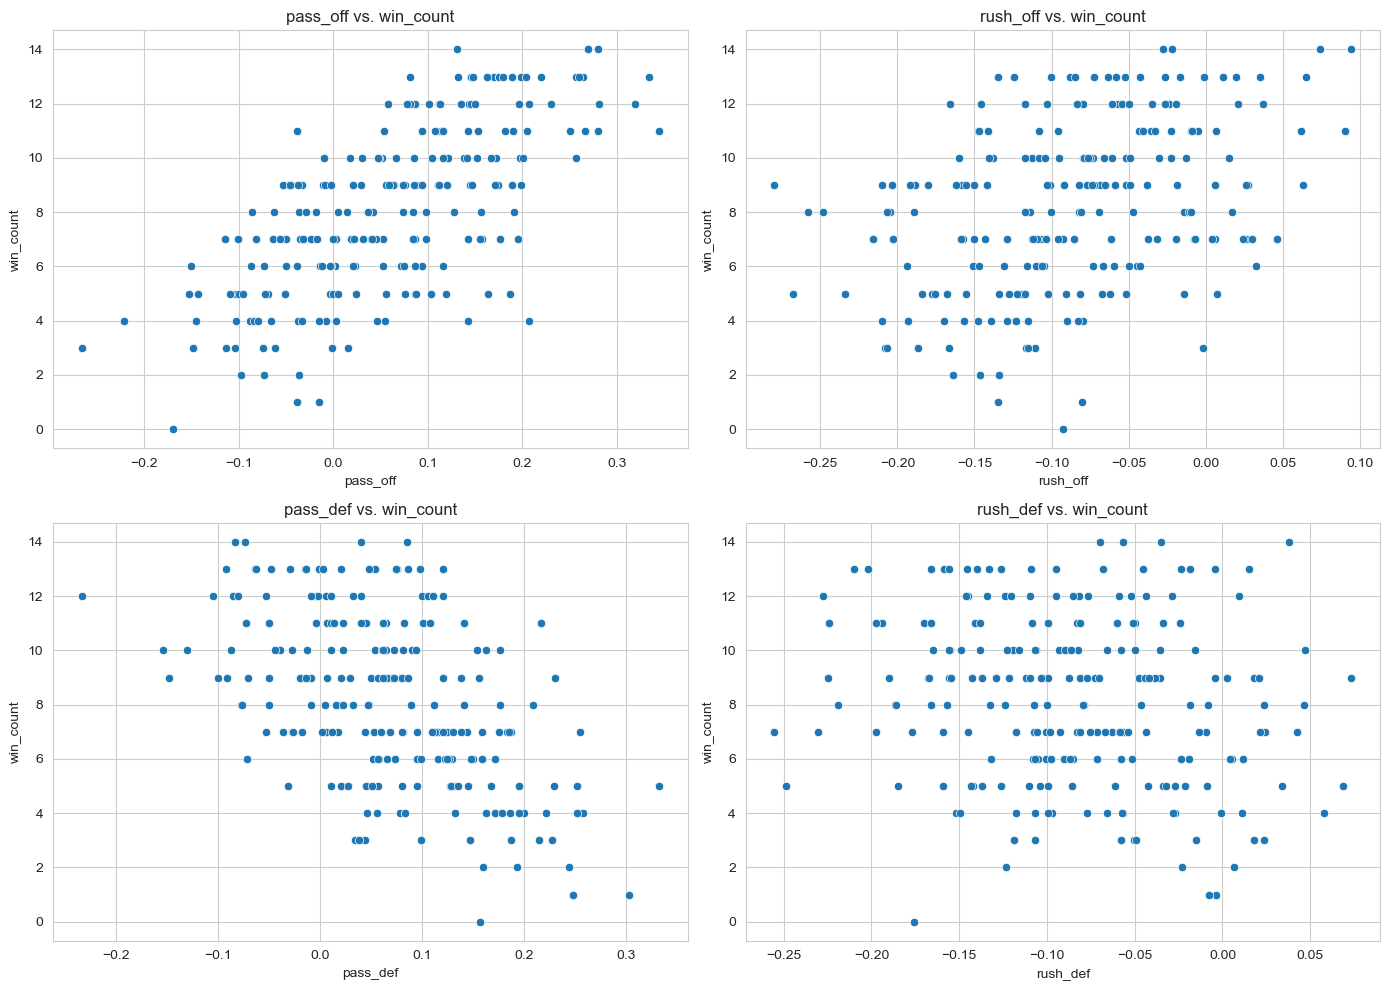

In [12]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.scatterplot(data=df, x='pass_off', y='win_count', ax=axes[0, 0])
axes[0, 0].set_title('pass_off vs. win_count')

sns.scatterplot(data=df, x='rush_off', y='win_count', ax=axes[0, 1])
axes[0, 1].set_title('rush_off vs. win_count')

sns.scatterplot(data=df, x='pass_def', y='win_count', ax=axes[1, 0])
axes[1, 0].set_title('pass_def vs. win_count')

sns.scatterplot(data=df, x='rush_def', y='win_count', ax=axes[1, 1])
axes[1, 1].set_title('rush_def vs. win_count')

plt.tight_layout()
plt.show()

In [7]:
# 1. Extracting predictors and target
X = df[['pass_off', 'rush_off', 'pass_def', 'rush_def']]
y = df['win_count'].values

def chart_preds(df, x = 'win_count', y='predicted_win_count'):
    plt.figure(figsize=(12, 8))
    plt.scatter(df[x], df[y], color='blue')
    for idx, row in df.iterrows():
        plt.annotate(row['team'], (row[x], row[y]), fontsize=9)
    plt.plot([df[x].min(), df[x].max()], 
        [df[x].min(), df[x].max()], 
        color='red', linestyle='--')
    plt.title(f'{x} vs. {y}')
    plt.xlabel(f'{x}')
    plt.ylabel(f'{y}')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

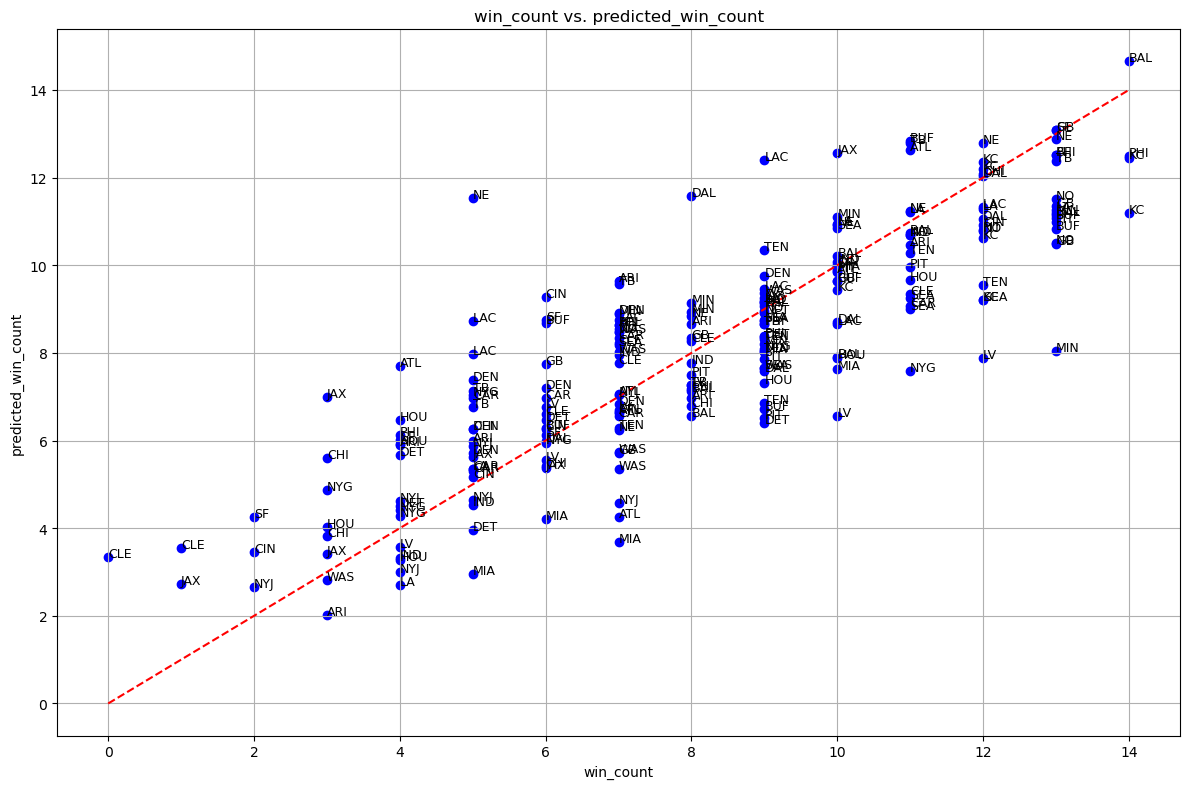

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model_original = LinearRegression()
model_original.fit(X, y)
df['predicted_win_count'] = model_original.predict(X)

chart_preds(df.copy())

The linear regression model seems to underestimate teams with high actual win counts and overestimate those with low actual win counts. Let's try some Feature Engineering to see if we can improve the model. Maybe creating polynomial features could capture the non-linearity in the relationship.

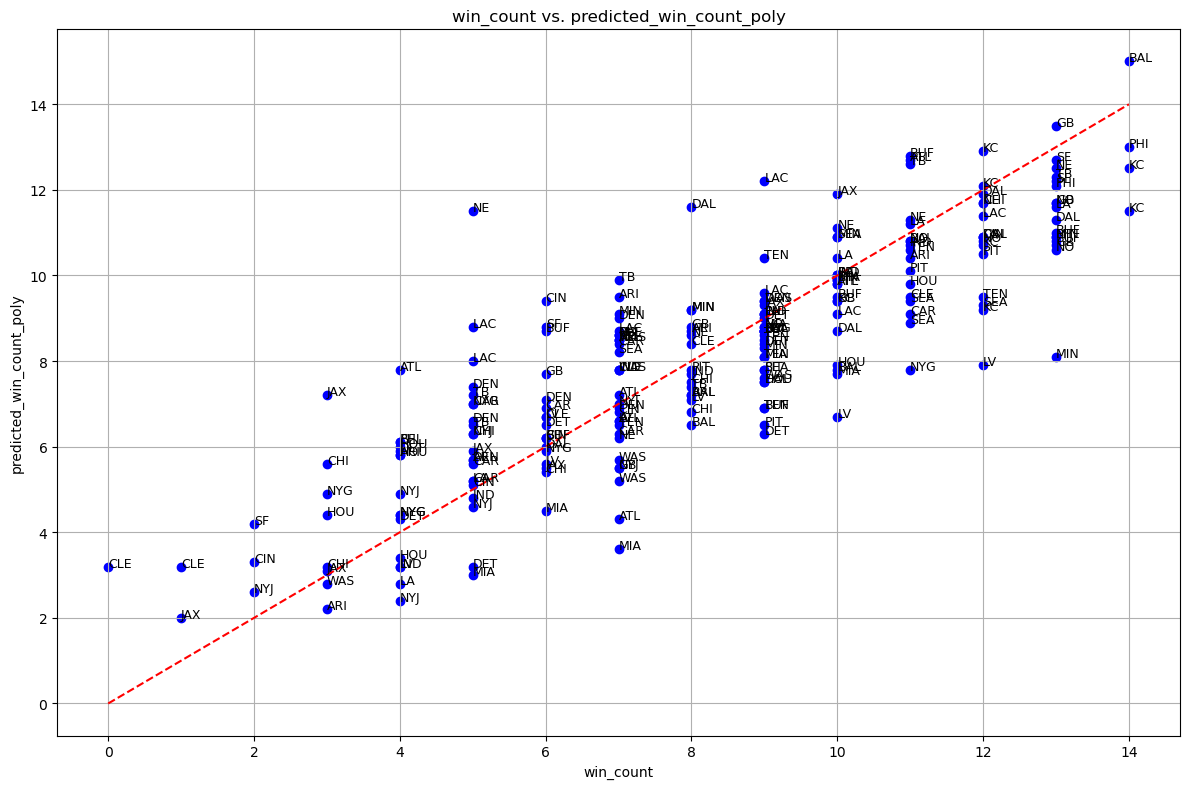

In [9]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

model_poly = LinearRegression()
model_poly.fit(X_poly, y)

df['predicted_win_count_poly'] = model_poly.predict(X_poly)
df['predicted_win_count_poly'] = round(df['predicted_win_count_poly'], 1)
df['residuals_poly'] = df['win_count'] - df['predicted_win_count_poly']

chart_preds(df.copy(), x='win_count', y='predicted_win_count_poly')

In [10]:
mse_original = mean_squared_error(df['win_count'], df['predicted_win_count'])
mse_poly = mean_squared_error(df['win_count'], df['predicted_win_count_poly'])

mse_original, mse_poly

(2.6391512916726585, 2.575446428571429)

Polynomical features slightly improved the model but not by much and the original problem of overestimating low win teams and underestimating high win teams still exists. Let's examine some of the assumptions of linear regression (e.g., linearity, homoscedasticity, independence, normality).

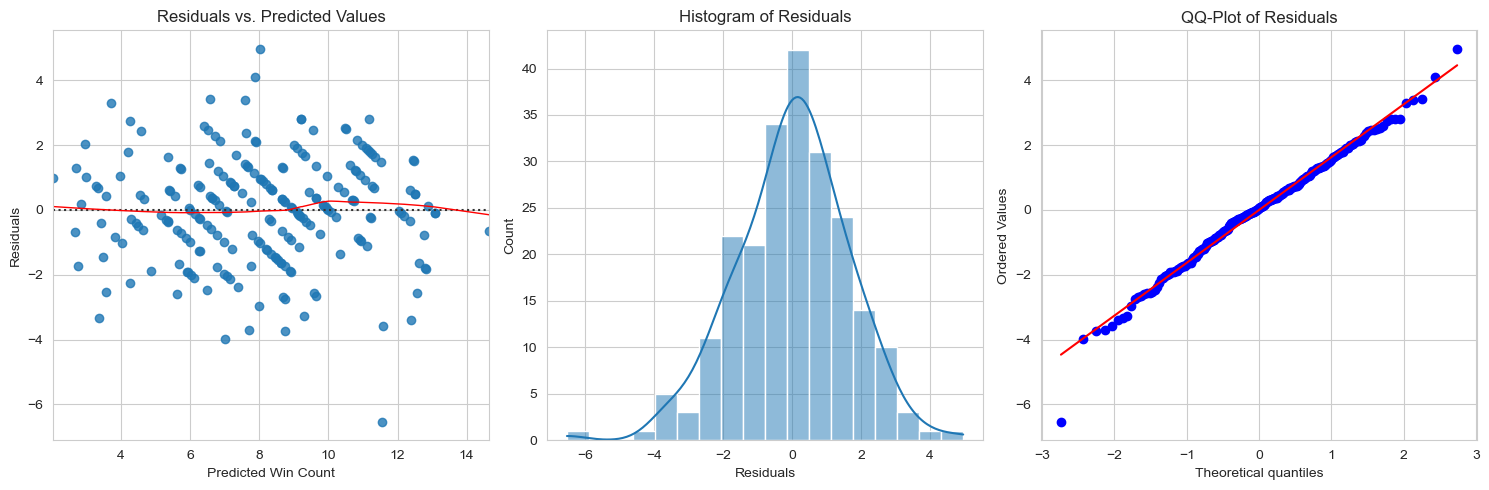

In [16]:
import scipy.stats as stats

# Calculate residuals for the original linear regression
df['residuals_original'] = df['win_count'] - df['predicted_win_count']

# Plotting residuals
plt.figure(figsize=(15, 5))

# Residuals vs. Predicted values (to check for linearity and homoscedasticity)
plt.subplot(1, 3, 1)
sns.residplot(x=df['predicted_win_count'], y=df['residuals_original'], lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Win Count')
plt.ylabel('Residuals')

# Histogram of residuals (to check for normality)
plt.subplot(1, 3, 2)
sns.histplot(df['residuals_original'], kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')

# QQ-plot (to check for normality)
plt.subplot(1, 3, 3)
stats.probplot(df['residuals_original'], plot=plt)
plt.title('QQ-Plot of Residuals')

plt.tight_layout()
plt.show()

NOTE - provide some interpretation of the above.

Let's try implementing a Random Forest regression model. Random Forest is an ensemble learning method that can capture complex, non-linear relationships in the data. It works by building multiple decision trees during training and outputs the average prediction of the individual trees for regression tasks.

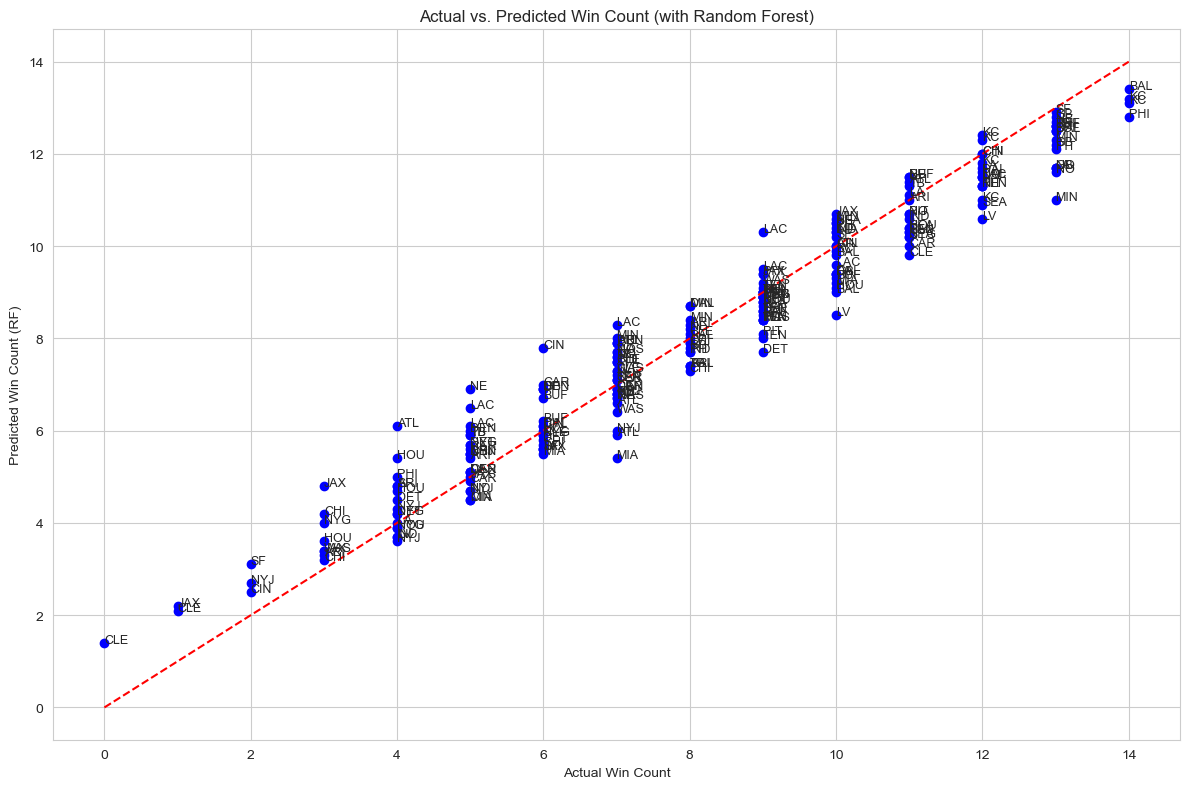

0.48107142857142854

In [17]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the original predictors
rf_model.fit(X, y)

# Predict using the Random Forest model
df['predicted_win_count_rf'] = rf_model.predict(X)
df['predicted_win_count_rf'] = round(df['predicted_win_count_rf'], 1)
df['residuals_rf'] = df['win_count'] - df['predicted_win_count_rf']

# Plotting the results
plt.figure(figsize=(12, 8))
plt.scatter(df['win_count'], df['predicted_win_count_rf'], color='blue')
for idx, row in df.iterrows():
    plt.annotate(row['team'], (row['win_count'], row['predicted_win_count_rf']), fontsize=9)
plt.plot([df['win_count'].min(), df['win_count'].max()], 
         [df['win_count'].min(), df['win_count'].max()], 
         color='red', linestyle='--')
plt.title('Actual vs. Predicted Win Count (with Random Forest)')
plt.xlabel('Actual Win Count')
plt.ylabel('Predicted Win Count (RF)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate MSE for Random Forest model
mse_rf = mean_squared_error(df['win_count'], df['predicted_win_count_rf'])

mse_rf

In [2]:
pbp = pd.read_csv('scrape/nfl_data_py/df_pbp_2016_2022.csv')
pbp = pbp[(pbp['season_type'] == 'REG')]

C:\Users\grant\AppData\Local\Temp\ipykernel_25652\276358757.py:1: DtypeWarning: Columns (179,180,182,183,189,190,193,194,197,198,203,204,205,206,209,210,213,214,218,219,220,222,224,226,233,234,235,236,237,238,243,244,245,248,249,253,254,255,260,262,263,266,267,268,269,283,284,301) have mixed types. Specify dtype option on import or set low_memory=False.
  pbp = pd.read_csv('scrape/nfl_data_py/df_pbp_2016_2022.csv')


In [44]:
fumbles = pbp[pbp['fumble_lost'] == 1]
fumbles = fumbles[['season', 'week', 'fumbled_1_team']]
fumbles.rename(columns={'fumbled_1_team': 'team'}, inplace=True)
fumbles = fumbles.groupby(['season', 'week','team']).size().reset_index(name='fumbles').sort_values(['season','team', 'week'])

interceptions = pbp[pbp['interception'] == 1]
interceptions = interceptions[['season', 'week', 'posteam']]
interceptions.rename(columns={'posteam': 'team'}, inplace=True)
interceptions = interceptions.groupby(['season', 'week','team']).size().reset_index(name='interceptions').sort_values(['season', 'team', 'week'])

turnovers = pd.merge(fumbles, interceptions, on=['team', 'week', 'season'], how='outer')
turnovers.fillna(0, inplace=True)
turnovers['turnovers'] = turnovers['fumbles'] + turnovers['interceptions']

schedule = pbp[pbp['desc'] == 'END GAME']
schedule = schedule[['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']].drop_duplicates().reset_index(drop=True)

df = pd.merge(schedule, turnovers[['season', 'week','team', 'turnovers']].rename(columns={'team': 'home_team', 'turnovers': 'home_turnovers'}), on=['season', 'week', 'home_team'], how='left')
df = pd.merge(df, turnovers[['season', 'week','team', 'turnovers']].rename(columns={'team': 'away_team', 'turnovers': 'away_turnovers'}), on=['season', 'week', 'away_team'], how='left')
df.fillna(0, inplace=True)
df['home_vs_away_turnovers'] = df['home_turnovers'] - df['away_turnovers']
df['home_vs_away_score'] = df['home_score'] - df['away_score']
df['home_outcome'] = 'Loss'
df.loc[df['home_vs_away_score'] > 0, 'home_outcome'] = 'Win'
df.loc[df['home_vs_away_score'] == 0, 'home_outcome'] = 'Tie'
df['home_win_binary'] = 0
df.loc[df['home_vs_away_score'] > 0, 'home_win_binary'] = 1
df.head()

,season,week,home_team,away_team,home_score,away_score,home_turnovers,away_turnovers,home_vs_away_turnovers,home_vs_away_score,home_outcome,home_win_binary
0,2016,1,BAL,BUF,13,7,1.0,0.0,1.0,6,Win,1
1,2016,1,DEN,CAR,21,20,3.0,1.0,2.0,1,Win,1
2,2016,1,HOU,CHI,23,14,1.0,1.0,0.0,9,Win,1
3,2016,1,NYJ,CIN,22,23,1.0,1.0,0.0,-1,Loss,0
4,2016,1,PHI,CLE,29,10,0.0,1.0,-1.0,19,Win,1


In [46]:
round(df['home_outcome'].value_counts() / len(df), 3)

Win     0.544
Loss    0.451
Tie     0.005
Name: home_outcome, dtype: float64

In [48]:
round(df[df['season'] != 2020]['home_outcome'].value_counts() / len(df[df['season'] != 2020]), 3)

Win     0.552
Loss    0.443
Tie     0.005
Name: home_outcome, dtype: float64

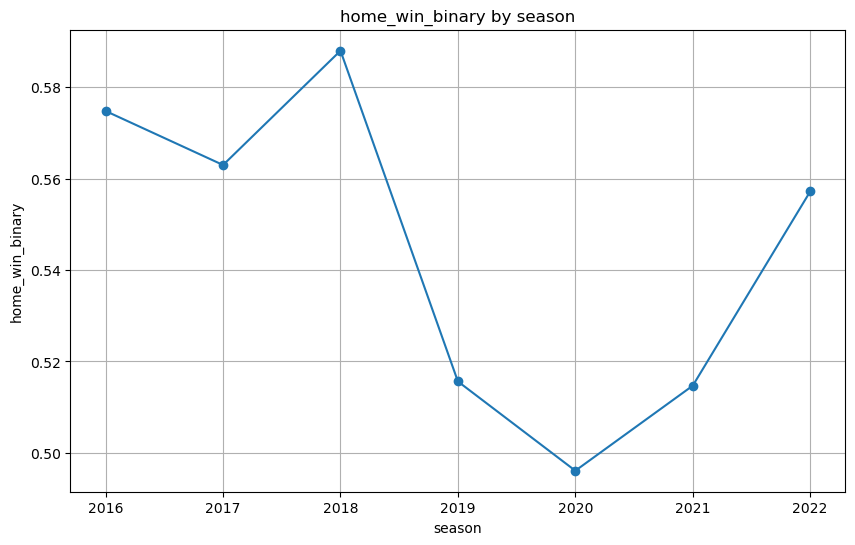

In [49]:
y = 'home_win_binary'
x = 'season'

test = df.groupby(x)[y].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(test[x], test[y], marker='o')
plt.title(f'{y} by {x}')
plt.xlabel(f'{x}')
plt.ylabel(f'{y}')
plt.grid(True)
plt.show()

In [51]:
df['home_vs_away_score'].mean()

1.4964147821290679

In [50]:
df[df['season'] != 2020]['home_vs_away_score'].mean()

1.7334617854849068

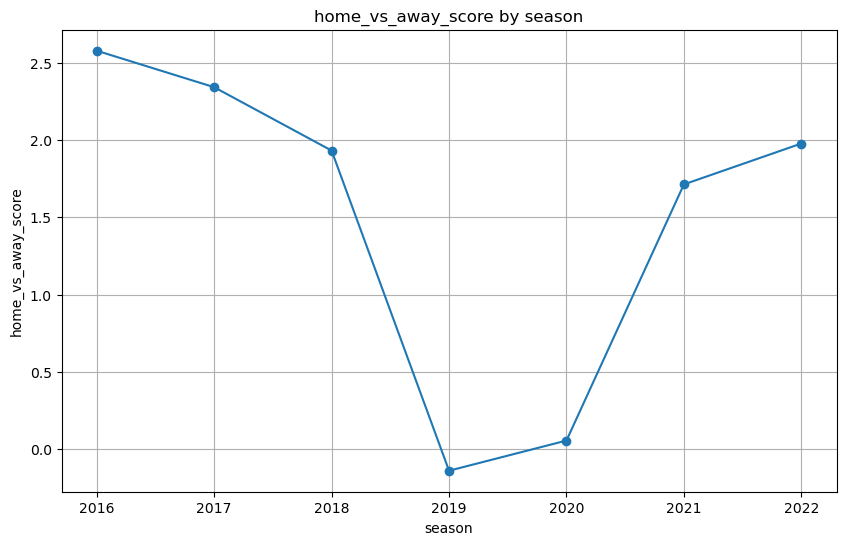

In [40]:
y = 'home_vs_away_score'
x = 'season'

test = df.groupby(x)[y].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(test[x], test[y], marker='o')
plt.title(f'{y} by {x}')
plt.xlabel(f'{x}')
plt.ylabel(f'{y}')
plt.grid(True)
plt.show()

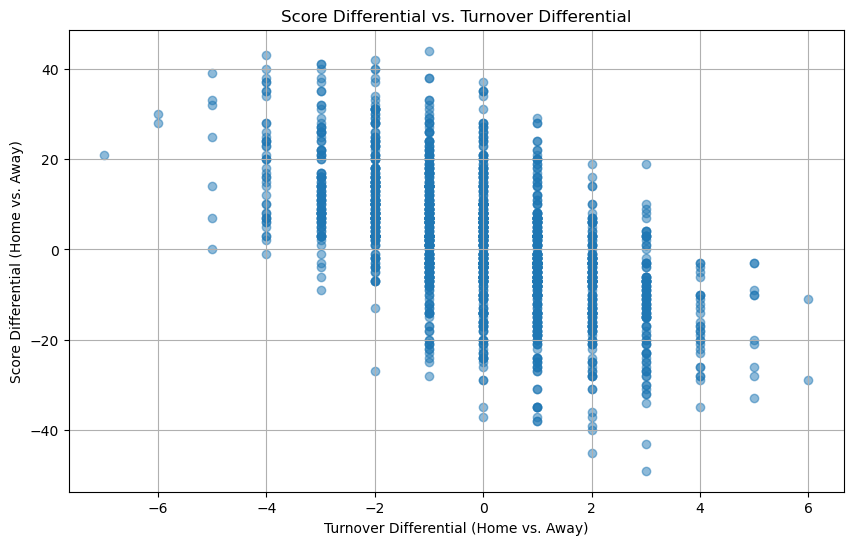

In [22]:
data = df.copy()

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['home_vs_away_turnovers'], data['home_vs_away_score'], alpha=0.5)
plt.title('Score Differential vs. Turnover Differential')
plt.xlabel('Turnover Differential (Home vs. Away)')
plt.ylabel('Score Differential (Home vs. Away)')
plt.grid(True)
plt.show()

In [5]:
correlation_coefficient = data['home_vs_away_turnovers'].corr(data['home_vs_away_score'])
correlation_coefficient

-0.5836223762967452

In [7]:
# Group by turnover differential and calculate the win rate
win_rate_by_turnover_diff = data.groupby('home_vs_away_turnovers')['home_outcome'].apply(lambda x: (x == 'Win').sum() / len(x)).reset_index()
win_rate_by_turnover_diff.columns = ['Turnover Differential', 'Win Rate']

# Calculate the number of games for each turnover differential
num_games_by_turnover_diff = data.groupby('home_vs_away_turnovers')['home_outcome'].count().reset_index()
num_games_by_turnover_diff.columns = ['Turnover Differential', 'Number of Games']

# Merge with the win rate table
win_rate_by_turnover_diff = win_rate_by_turnover_diff.merge(num_games_by_turnover_diff, on='Turnover Differential')

# Format the win rate to two decimal places
win_rate_by_turnover_diff['Win Rate'] = win_rate_by_turnover_diff['Win Rate'].round(2)

win_rate_by_turnover_diff

,Turnover Differential,Win Rate,Number of Games
0,-7.0,1.00,1
1,-6.0,1.00,2
2,-5.0,0.86,7
3,-4.0,0.98,42
4,-3.0,0.95,103
5,-2.0,0.90,220
6,-1.0,0.69,331
7,0.0,0.58,412
8,1.0,0.34,357
9,2.0,0.18,191


In [19]:
data[(data['home_vs_away_turnovers'] == -5.0) & (data['home_outcome'] == 'Tie')]

,season,week,home_team,away_team,home_score,away_score,home_turnovers,away_turnovers,home_vs_away_turnovers,home_vs_away_score,home_outcome
517,2018,1,CLE,PIT,21,21,1.0,6.0,-5.0,0,Tie


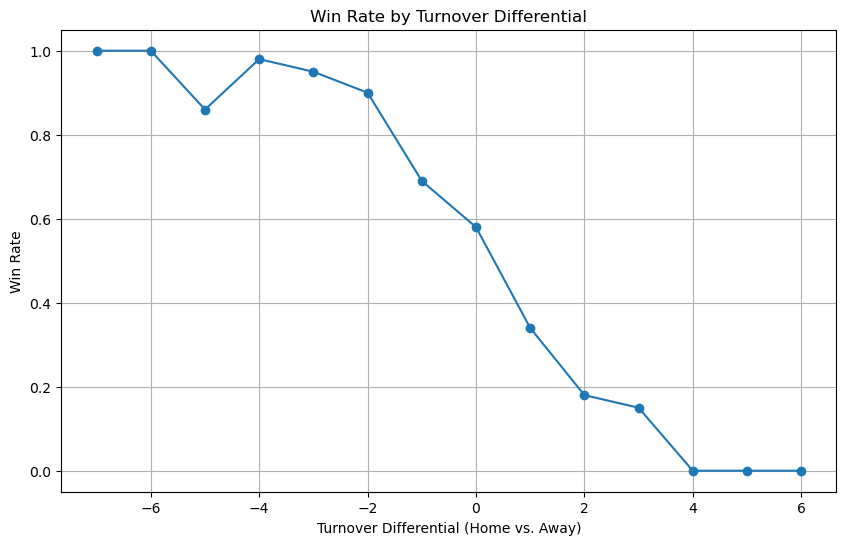

In [8]:
# Plotting the win rate against turnover differential
plt.figure(figsize=(10, 6))
plt.plot(win_rate_by_turnover_diff['Turnover Differential'], win_rate_by_turnover_diff['Win Rate'], marker='o')
plt.title('Win Rate by Turnover Differential')
plt.xlabel('Turnover Differential (Home vs. Away)')
plt.ylabel('Win Rate')
plt.grid(True)
plt.show()

In [9]:
# Calculate the average turnover differential for home games
avg_home_turnover_diff = data['home_vs_away_turnovers'].mean()

# Calculate the average turnover differential for away games (which is the negative of home turnover differential)
avg_away_turnover_diff = -avg_home_turnover_diff

avg_home_turnover_diff, avg_away_turnover_diff

(-0.03695532266960838, 0.03695532266960838)